<a href="https://colab.research.google.com/github/shreyaghotankar/CMPE-255-Data-Mining/blob/master/CMPE_255_Assignment_Gradient_Boost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPE 255 - Assignment - Gradient Boost

Demonstrate gradient boost methods

a) Showcase  gbm classifier techniques

b) Showcase gradient boost regression techniques

c) showcase gradient boost ranking techniques

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install gensim
!pip install catboost
!pip install nltk
!pip install shap
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 76.3 MB 1.2 MB/s 
     |████████████████████████████████| 564 kB 7.1 MB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [4]:
%matplotlib inline
import numpy as np
from numpy import mean
from numpy import std
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from lightgbm import LGBMRanker
from catboost import CatBoostRanker, Pool, MetricVisualizer, eval
from copy import deepcopy
import xgboost as xgb
from sklearn.datasets import load_svmlight_file
from xgboost import XGBRanker

import shap

import seaborn as sns
import string
from time import time
from pandas.api.types import CategoricalDtype

from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

import gensim
import re
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Classifier Techniques

Gradient Boost Classifier techniques - 
* XGBoost, 
* Catboost, 
* LightGBM, 
* Random Forest, 
* AdaBoost, 
* Decision Tree

### Data prep and visualization

using Amazon Kindle Book Review dataset from Kaggle

In [ ]:
df_amz_reviews = pd.read_csv('/content/drive/MyDrive/CMPE255 - Data Mining/Assignments/Datasets/all_kindle_review .csv')

In [ ]:
df_amz_reviews

,Unnamed: 0,Unnamed: 0.1,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,11539,B0033UV8HI,"[8, 10]",3,"Jace Rankin may be short, but he's nothing to ...","09 2, 2010",A3HHXRELK8BHQG,Ridley,Entertaining But Average,1283385600
1,1,5957,B002HJV4DE,"[1, 1]",5,Great short read. I didn't want to put it dow...,"10 8, 2013",A2RGNZ0TRF578I,Holly Butler,Terrific menage scenes!,1381190400
2,2,9146,B002ZG96I4,"[0, 0]",3,I'll start by saying this is the first of four...,"04 11, 2014",A3S0H2HV6U1I7F,Merissa,Snapdragon Alley,1397174400
3,3,7038,B002QHWOEU,"[1, 3]",3,Aggie is Angela Lansbury who carries pocketboo...,"07 5, 2014",AC4OQW3GZ919J,Cleargrace,very light murder cozy,1404518400
4,4,1776,B001A06VJ8,"[0, 1]",4,I did not expect this type of book to be in li...,"12 31, 2012",A3C9V987IQHOQD,Rjostler,Book,1356912000
...,...,...,...,...,...,...,...,...,...,...,...
11995,11995,2183,B001DUGORO,"[0, 0]",4,Valentine cupid is a vampire- Jena and Ian ano...,"02 28, 2014",A1OKS5Q1HD8WQC,lisa jon jung,jena,1393545600
11996,11996,6272,B002JCSFSQ,"[2, 2]",5,I have read all seven books in this series. Ap...,"05 16, 2011",AQRSPXLNEQAMA,TerryLP,Peacekeepers Series,1305504000
11997,11997,12483,B0035N1V7K,"[0, 1]",3,This book really just wasn't my cuppa. The si...,"07 26, 2013",A2T5QLT5VXOJAK,hwilson,a little creepy,1374796800
11998,11998,3640,B001W1XT40,"[1, 2]",1,"tried to use it to charge my kindle, it didn't...","09 17, 2013",A28MHD2DDY6DXB,"Allison A. Slater ""Gryphon50""",didn't work,1379376000


In [ ]:
#df_amz_reviews = df_amz_reviews.sample(n=6000)

In [ ]:
col = ['asin','rating','reviewText']
df_amaz_reviews = df_amz_reviews[col].copy()
df_amaz_reviews.reset_index(drop=True, inplace=True)

df_amaz_reviews

,asin,rating,reviewText
0,B0033UV8HI,3,"Jace Rankin may be short, but he's nothing to ..."
1,B002HJV4DE,5,Great short read. I didn't want to put it dow...
2,B002ZG96I4,3,I'll start by saying this is the first of four...
3,B002QHWOEU,3,Aggie is Angela Lansbury who carries pocketboo...
4,B001A06VJ8,4,I did not expect this type of book to be in li...
...,...,...,...
11995,B001DUGORO,4,Valentine cupid is a vampire- Jena and Ian ano...
11996,B002JCSFSQ,5,I have read all seven books in this series. Ap...
11997,B0035N1V7K,3,This book really just wasn't my cuppa. The si...
11998,B001W1XT40,1,"tried to use it to charge my kindle, it didn't..."


In [ ]:
df_amaz_reviews.rating.unique()

array([3, 5, 4, 2, 1])

In [ ]:
df_amaz_reviews.isna().sum()

asin          0
rating        0
reviewText    0
dtype: int64

In [ ]:
df_amaz_reviews.duplicated().sum()

0

In [ ]:
df_amaz_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   asin        12000 non-null  object
 1   rating      12000 non-null  int64 
 2   reviewText  12000 non-null  object
dtypes: int64(1), object(2)
memory usage: 281.4+ KB


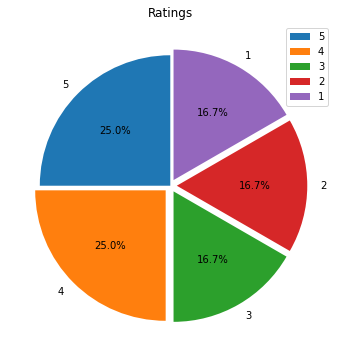

In [ ]:
fig = plt.figure(figsize = (6,6))
labels = df_amaz_reviews['rating'].value_counts().index.tolist()
sizes = df_amaz_reviews['rating'].value_counts().tolist()
plt.pie(sizes, labels = labels, autopct = '%1.1f%%',
        shadow = False, startangle = 90, explode=(0,0.05, 0.05, 0.05, 0.05))

plt.legend()
plt.title('Ratings')
plt.show()

### Preprocessing

In [ ]:
stops = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.SnowballStemmer('english')
wrdlemmatizer = WordNetLemmatizer()
tokenizer = nltk.word_tokenize

In [ ]:
def dataCleaning(data):
  review = re.sub('[^a-zA-Z]', ' ', str(data)) # removing special characters

  review = review.lower() # lower case

  review = review.translate(str.maketrans('', '', string.punctuation)) # remove punctuations

  review_words = tokenizer(review) # tokenize

  words = [w for w in review_words if not w in stops] # stopwords removal;

  wordnet_lemm = [wrdlemmatizer.lemmatize(w) for w in words] # lemmatize

  stemms = [stemmer.stem(w) for w in wordnet_lemm] # stemming

  word_stemm = ' '.join(word for word in stemms if len(word) > 2)



  return word_stemm

In [ ]:
df_amaz_reviews['words'] = df_amaz_reviews['reviewText'].apply(dataCleaning)
df_amaz_reviews

,asin,rating,reviewText,words
0,B0033UV8HI,3,"Jace Rankin may be short, but he's nothing to ...",jace rankin may short noth mess man haul saloo...
1,B002HJV4DE,5,Great short read. I didn't want to put it dow...,great short read want put read one sit sex sce...
2,B002ZG96I4,3,I'll start by saying this is the first of four...,start say first four book expect conclud cente...
3,B002QHWOEU,3,Aggie is Angela Lansbury who carries pocketboo...,aggi angela lansburi carri pocketbook instead ...
4,B001A06VJ8,4,I did not expect this type of book to be in li...,expect type book librari pleas find price right
...,...,...,...,...
11995,B001DUGORO,4,Valentine cupid is a vampire- Jena and Ian ano...,valentin cupid vampir jena ian anoth vampir fi...
11996,B002JCSFSQ,5,I have read all seven books in this series. Ap...,read seven book seri apocalypt adventur one fa...
11997,B0035N1V7K,3,This book really just wasn't my cuppa. The si...,book realli cuppa situat man captur woman work...
11998,B001W1XT40,1,"tried to use it to charge my kindle, it didn't...",tri use charg kindl even regist charg complet ...


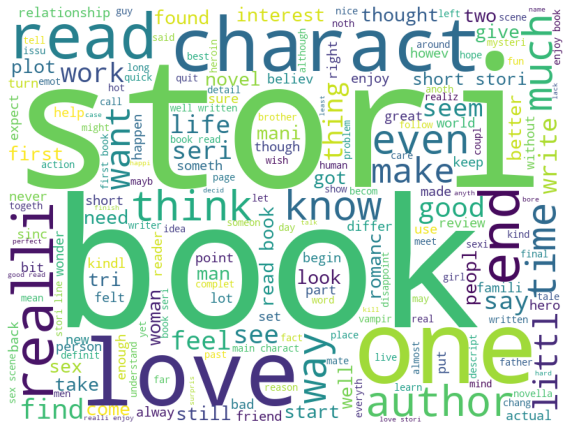

In [ ]:
def wordcloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (10, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

wordcloud(' '.join(df_amaz_reviews['words']))

### Run Classifiers

In [ ]:
X = df_amaz_reviews.drop(columns=['asin','rating'], axis=1)
y = df_amaz_reviews['rating']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.20, random_state=42)

In [ ]:
tfidf = TfidfVectorizer()

In [ ]:
X_train_features = tfidf.fit_transform(X_train['words']).toarray()
X_test_features = tfidf.transform(X_test['words']).toarray()

In [ ]:
X_train_features.shape

(2400, 9538)

In [ ]:
def call_all_models(models, X_train, X_test, X_valid, y_train, y_test, y_valid):
  res = []
  for name, model in models:
    start_time = time()
    #model.fit(X_train, y_train)
    if model in ['CatBoost']:
      model.fit(X_train, y_train, 
                eval_set = [(X_valid, y_valid)],
                early_stopping_rounds=15,
                verbose=0)
    else:
      model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    runTime = time() - start_time
    res.append([name, acc, runTime])
  return res

In [ ]:
X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(X_train_features, y_train, test_size=0.1)

In [ ]:
classifiers = []
classifiers.append(('XGBoost', XGBClassifier()))
classifiers.append(('LightGBM', LGBMClassifier(n_estimators=2000, feature_fraction=0.06, bagging_fraction=0.67, bagging_freq=1, verbose=0, n_jobs=6, random_state=800)))
classifiers.append(('CatBoost', CatBoostClassifier(verbose=0, n_estimators=100)))
classifiers.append(('Random Forest Classifier', RandomForestClassifier(n_estimators=500, max_features=0.06, n_jobs=6, random_state=None)))
classifiers.append(('Decision Tree Classifier', DecisionTreeClassifier(max_depth=12, random_state=500)))
classifiers.append(('AdaBoost', AdaBoostClassifier()))

In [ ]:
res = call_all_models(classifiers, X_train_sub, X_test_features, X_valid, y_train_sub, y_test, y_valid)

In [ ]:
df_res = pd.DataFrame(res, columns=['model', 'accuracy', 'time'])
df_res

,model,accuracy,time
0,XGBoost,0.405521,207.175109
1,LightGBM,0.367917,118.691987
2,CatBoost,0.414896,89.483188
3,Random Forest Classifier,0.421875,116.630742
4,Decision Tree Classifier,0.316667,2.938793
5,AdaBoost,0.380417,34.887686


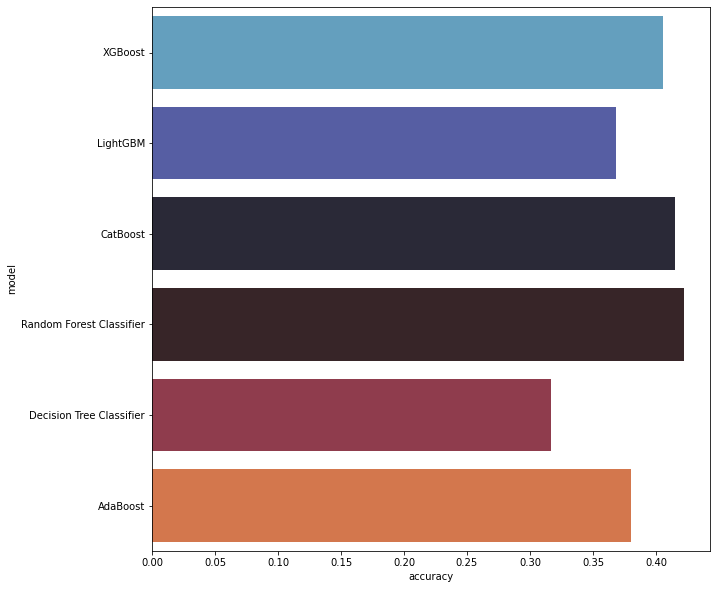

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x=df_res['accuracy'], y=df_res['model'], palette='icefire')

plt.show()

From all of the gradient boost classifiers Random Forest Classifier performed well based on it's accuracy score. If we factor in the time taken to run and accuracy CatBoost performed well.

## Regressor Techniques

Gradient Boost regression techniques - 
* XGBoost, 
* Catboost, 
* LightGBM

### Data Prep

Using Loan Amount Dataset from Kaggle

In [ ]:
df_loan = pd.read_csv('/content/drive/MyDrive/CMPE255 - Data Mining/Assignments/Datasets/loan_dataset.csv')

In [ ]:
df_loan

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0.0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500.0,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800.0,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546.0,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0.0,78.0,360.0,1.0,Urban
...,...,...,...,...,...,...,...,...,...,...,...,...
976,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural
977,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural
978,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban
979,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban


In [ ]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            981 non-null    object 
 1   Gender             957 non-null    object 
 2   Married            978 non-null    object 
 3   Dependents         956 non-null    object 
 4   Education          981 non-null    object 
 5   Self_Employed      926 non-null    object 
 6   ApplicantIncome    981 non-null    int64  
 7   CoapplicantIncome  981 non-null    float64
 8   LoanAmount         954 non-null    float64
 9   Loan_Amount_Term   961 non-null    float64
 10  Credit_History     902 non-null    float64
 11  Property_Area      981 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 92.1+ KB


In [ ]:
df_loan.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,981.000000,981.000000,954.000000,961.000000,902.000000
mean,5179.795107,1601.916330,142.511530,342.201873,0.835920
std,5695.104533,2718.772806,77.421743,65.100602,0.370553
min,0.000000,0.000000,9.000000,6.000000,0.000000
25%,2875.000000,0.000000,100.000000,360.000000,1.000000
50%,3800.000000,1110.000000,126.000000,360.000000,1.000000
75%,5516.000000,2365.000000,162.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [ ]:
df_loan.isna().sum().sort_values(ascending=False)

Credit_History       79
Self_Employed        55
LoanAmount           27
Dependents           25
Gender               24
Loan_Amount_Term     20
Married               3
Property_Area         0
CoapplicantIncome     0
ApplicantIncome       0
Education             0
Loan_ID               0
dtype: int64

In [ ]:
# replace null values with mean
df_loan['Dependents'].fillna(value=1, inplace= True)

# replace null value with maximum occuring value
df_loan['Gender'].fillna(df_loan.Gender.mode().to_string(), inplace=True)

# replace null with maximum occurring value
df_loan['Self_Employed'].fillna(df_loan.Self_Employed.mode().to_string(), inplace=True)

# replace null values with mean
df_loan['Credit_History'].fillna(value=round(df_loan.Credit_History.mean()), inplace=True)

# replace null with No
df_loan['Married'].fillna(value='No', inplace= True)

# replace null values with median
df_loan['Loan_Amount_Term'].fillna(value=round(df_loan.Loan_Amount_Term.median()), inplace=True)

# replace null values with median
df_loan['LoanAmount'].fillna(value=round(df_loan.LoanAmount.median()), inplace=True)

In [ ]:
df_loan.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

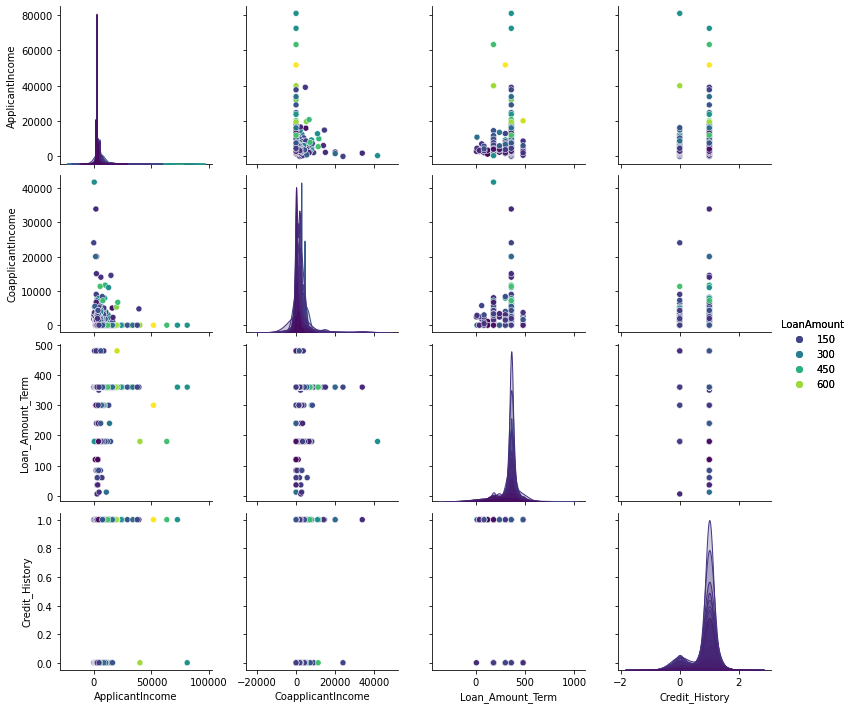

In [ ]:
sns.pairplot(df_loan, hue='LoanAmount', palette='viridis').add_legend()
plt.show()

In [ ]:
df_loan.duplicated().sum()

0

In [ ]:
df_loan['Dependents'] = df_loan.Dependents.replace('3+','3')
df_loan['Dependents'] = df_loan.Dependents.astype('int')

In [ ]:
df_loan.drop(columns=['Loan_ID'], inplace=True)

In [ ]:
categorical_columns = df_loan.select_dtypes(include='object').columns.tolist()
categorical_columns

['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

In [ ]:
X = df_loan.drop(columns = ['LoanAmount'])
y = df_loan['LoanAmount'].copy()

In [ ]:
le = LabelEncoder()
X[categorical_columns] = X[categorical_columns].apply(lambda x: le.fit_transform(x))

In [ ]:
sca = MinMaxScaler()
x = sca.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

Feature: 0, Score: 8.00000
Feature: 1, Score: 1.00000
Feature: 2, Score: 4.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 3.00000
Feature: 5, Score: 7.00000
Feature: 6, Score: 2.00000
Feature: 7, Score: 9.00000
Feature: 8, Score: 6.00000
Feature: 9, Score: 5.00000


<BarContainer object of 10 artists>

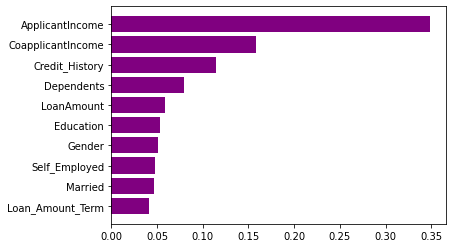

In [ ]:
# define the model
dtrcl = DecisionTreeClassifier()
# fit the model
dtrcl.fit(x, y)
# get importance
importance = dtrcl.feature_importances_
sorted_feature_importance = dtrcl.feature_importances_.argsort()
# summarize feature importance
for i,v in enumerate(sorted_feature_importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.barh(df_loan.columns[sorted_feature_importance], 
        dtrcl.feature_importances_[sorted_feature_importance], 
        color='purple')

From the shap values feature importance we can see that the LoanAmount, Dependents, Credit_History, CoapplicantIncome and ApplicantIncome are of high importance in comparison to all features in dataset.

Now we can work with features with importance.

In [ ]:
X_data = df_loan.drop(columns = ['LoanAmount', 'Married', 'Self_Employed', 'Education', 'Gender', 'Property_Area'])
y_data = df_loan['LoanAmount'].copy()

In [ ]:
sca = MinMaxScaler()
X_sc = sca.fit_transform(X_data)

In [ ]:
X_tr, X_tst, y_tr, y_tst = train_test_split(X_sc, y_data, test_size = 0.2)

### CatBoost Regressor

In [ ]:
cat_model = CatBoostRegressor(loss_function='RMSE')
# Fit model 
cat_model.fit( X_tr, y_tr,
               eval_set=(X_tst, y_tst),
               plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.049012
0:	learn: 73.6404410	test: 79.9375888	best: 79.9375888 (0)	total: 1.17ms	remaining: 1.17s
1:	learn: 72.4152746	test: 78.8095959	best: 78.8095959 (1)	total: 3.42ms	remaining: 1.71s
2:	learn: 71.2698780	test: 77.8250549	best: 77.8250549 (2)	total: 4.56ms	remaining: 1.51s
3:	learn: 70.2549355	test: 76.9463085	best: 76.9463085 (3)	total: 5.62ms	remaining: 1.4s
4:	learn: 69.3233932	test: 76.1960153	best: 76.1960153 (4)	total: 6.25ms	remaining: 1.24s
5:	learn: 68.4171626	test: 75.3977616	best: 75.3977616 (5)	total: 7.21ms	remaining: 1.19s
6:	learn: 67.5011484	test: 74.8112709	best: 74.8112709 (6)	total: 8.17ms	remaining: 1.16s
7:	learn: 66.4905122	test: 73.9326269	best: 73.9326269 (7)	total: 9.13ms	remaining: 1.13s
8:	learn: 65.5417827	test: 73.3512529	best: 73.3512529 (8)	total: 10.1ms	remaining: 1.11s
9:	learn: 64.6743243	test: 72.8665837	best: 72.8665837 (9)	total: 11.2ms	remaining: 1.11s
10:	learn: 63.8712684	test: 72.2638494	best: 72.2638494 (10)	total: 12.

In [ ]:
feat_imp_srt = cat_model.feature_importances_.argsort()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


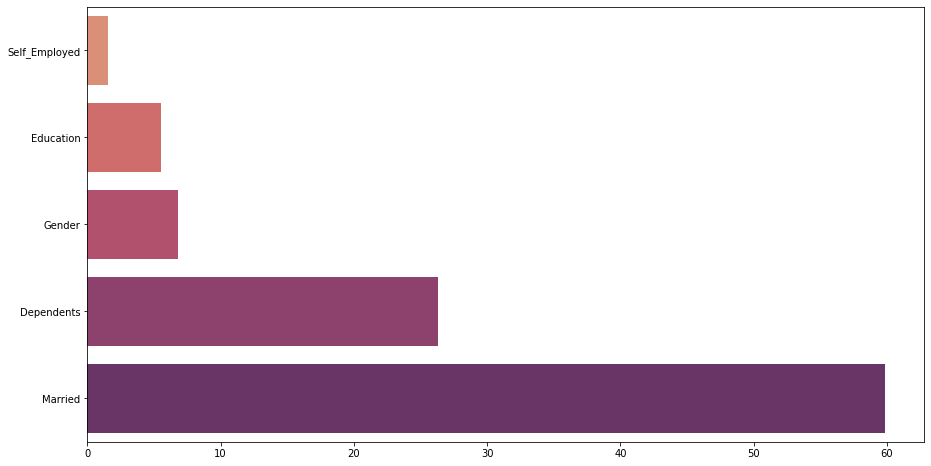

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(cat_model.feature_importances_[feat_imp_srt], df_loan.columns[feat_imp_srt], palette='flare')
plt.show()

In [ ]:
y_pred= cat_model.predict(X_tst)

Rmse_test = math.sqrt(mean_squared_error(y_tst,y_pred))

r2_test = r2_score(y_tst,y_pred)

print("For CatBoost Regressor:")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))

For CatBoost Regressor:
RMSE: 64.24
R2: 0.38


### XGBoost Regressor

In [ ]:
xgbr_model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_sc, y_data, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
xgbr_model.fit(X_tr, y_tr, verbose=False)

[04:56:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, eta=0.1, max_depth=7, n_estimators=1000,
             subsample=0.7)

In [ ]:
y_predict = xgbr_model.predict(X_tst)
acc_xgbr = r2_score(y_tst, y_predict)
print("Accuracy for XGBoost Regressor: \n", acc_xgbr)

Accuracy for XGBoost Regressor: 
 0.22061518256123425


### LightGBM Regressor

In [ ]:
lgbmr_model = LGBMRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(lgbmr_model, X_sc, y_data, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: -37.609 (4.065)


In [ ]:
lgbmr_model.fit(X_tr, y_tr)
y_prediction = lgbmr_model.predict(X_tst)
acc_lgbmr = r2_score(y_tst, y_prediction)
print("Accuracy for LightGBM Regressor:\n", acc_lgbmr)

Accuracy for LightGBM Regressor:
 0.3604803764527249


Out of the 3 regressors, CatBoost has comparatively better accuracy.

## Ranking Techniques

### XGBoost Ranker


Dataset - [Microsoft LETOR ranking](https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/letor-4-0/)

In [5]:
x_train, y_train = load_svmlight_file("/content/drive/MyDrive/CMPE255 - Data Mining/Assignments/Datasets/MQ2008/mq2008.train")
x_valid, y_valid = load_svmlight_file("/content/drive/MyDrive/CMPE255 - Data Mining/Assignments/Datasets/MQ2008/mq2008.vali")
x_test, y_test = load_svmlight_file("/content/drive/MyDrive/CMPE255 - Data Mining/Assignments/Datasets/MQ2008/mq2008.test")

group_train = []
with open("/content/drive/MyDrive/CMPE255 - Data Mining/Assignments/Datasets/MQ2008/mq2008.train.group", "r") as f:
    data = f.readlines()
    for line in data:
        group_train.append(int(line.split("\n")[0]))

group_valid = []
with open("/content/drive/MyDrive/CMPE255 - Data Mining/Assignments/Datasets/MQ2008/mq2008.vali.group", "r") as f:
    data = f.readlines()
    for line in data:
        group_valid.append(int(line.split("\n")[0]))

group_test = []
with open("/content/drive/MyDrive/CMPE255 - Data Mining/Assignments/Datasets/MQ2008/mq2008.test.group", "r") as f:
    data = f.readlines()
    for line in data:
        group_test.append(int(line.split("\n")[0]))

params = {'objective': 'rank:ndcg', 'learning_rate': 0.1,
          'gamma': 1.0, 'min_child_weight': 0.1,
          'max_depth': 6, 'n_estimators': 4}
model = xgb.sklearn.XGBRanker(**params)
model.fit(x_train, y_train, group_train, verbose=True,
          eval_set=[(x_valid, y_valid)], eval_group=[group_valid])
pred = model.predict(x_test)

[0]	eval_0-map:0.707814
[1]	eval_0-map:0.709222
[2]	eval_0-map:0.7082
[3]	eval_0-map:0.714009


### LGBMRanker

using the same dataset as previous

In [8]:
model_lgb = LGBMRanker()
model_lgb.fit(x_train, y_train, group=group_train, verbose=True,
          eval_set=[(x_valid, y_valid)], eval_group=[group_valid], eval_at=[5, 10 ], early_stopping_rounds=50)
pred = model_lgb.predict(x_test)

[1]	valid_0's ndcg@5: 0.693516	valid_0's ndcg@10: 0.745139
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's ndcg@5: 0.713674	valid_0's ndcg@10: 0.765186
[3]	valid_0's ndcg@5: 0.722563	valid_0's ndcg@10: 0.765496
[4]	valid_0's ndcg@5: 0.727462	valid_0's ndcg@10: 0.771534
[5]	valid_0's ndcg@5: 0.723049	valid_0's ndcg@10: 0.768245
[6]	valid_0's ndcg@5: 0.729753	valid_0's ndcg@10: 0.771502
[7]	valid_0's ndcg@5: 0.732155	valid_0's ndcg@10: 0.772638
[8]	valid_0's ndcg@5: 0.737345	valid_0's ndcg@10: 0.773876
[9]	valid_0's ndcg@5: 0.735585	valid_0's ndcg@10: 0.777505
[10]	valid_0's ndcg@5: 0.732014	valid_0's ndcg@10: 0.776077
[11]	valid_0's ndcg@5: 0.732411	valid_0's ndcg@10: 0.778706
[12]	valid_0's ndcg@5: 0.73062	valid_0's ndcg@10: 0.779399
[13]	valid_0's ndcg@5: 0.73033	valid_0's ndcg@10: 0.777122
[14]	valid_0's ndcg@5: 0.736341	valid_0's ndcg@10: 0.778273
[15]	valid_0's ndcg@5: 0.736512	valid_0's ndcg@10: 0.778647
[16]	valid_0's ndcg@5: 0.730491	valid_0's ndcg@10

### CatBoost Ranker

In [ ]:
from catboost.datasets import msrank_10k
train_df, test_df = msrank_10k()

X_train = train_df.drop([0, 1], axis=1).values
y_train = train_df[0].values
queries_train = train_df[1].values

X_test = test_df.drop([0, 1], axis=1).values
y_test = test_df[0].values
queries_test = test_df[1].values


In [ ]:
num_docs = X_train.shape[0]
print(num_docs)

10000


In [ ]:
X_train.shape[1]

136

In [ ]:
from collections import Counter
Counter(y_train).items()

dict_items([(2.0, 1326), (0.0, 5481), (1.0, 3000), (3.0, 142), (4.0, 51)])

In [ ]:
max_relevance = np.max(y_train)
y_train /= max_relevance
y_test /= max_relevance

In [ ]:
num_queries = np.unique(queries_train).shape[0]
num_queries

87

In [ ]:
# creating pools
train = Pool(
    data=X_train,
    label=y_train,
    group_id=queries_train
)

test = Pool(
    data=X_test,
    label=y_test,
    group_id=queries_test
)

In [ ]:
# dataset reading and saving
data_dir = './msrank'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

train_file = os.path.join(data_dir, 'train.csv')
test_file = os.path.join(data_dir, 'test.csv')

train_df.to_csv(train_file, index=False, header=False)
test_df.to_csv(test_file, index=False, header=False)

In [ ]:
description_file = os.path.join(data_dir, 'dataset.cd')
with open(description_file, 'w') as f:
    f.write('0\tLabel\n')
    f.write('1\tQueryId\n')

In [ ]:
Pool(data=train_file, column_description=description_file, delimiter=',')

In [ ]:
# setting params
default_params = {
    'iterations': 2000,
    'custom_metric': ['NDCG', 'PFound', 'AverageGain:top=10'],
    'verbose': False,
    'random_seed': 0,
}

params = {}


In [ ]:
def fit_model(loss_function, additional_params=None, train_pool=train, test_pool=test):
    parameters = deepcopy(default_params)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function
    
    if additional_params is not None:
        params.update(additional_params)
        
    model = CatBoostRanker(**params)
    model.fit(train_pool, eval_set=test_pool, plot=True)
    
    return model

In [ ]:
model = fit_model('RMSE', {'custom_metric': ['PrecisionAt:top=10', 'RecallAt:top=10', 'MAP:top=10']})

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5488205	best: 0.5488205 (0)	total: 65.4ms	remaining: 1m 5s
1:	test: 0.5969069	best: 0.5969069 (1)	total: 126ms	remaining: 1m 2s
2:	test: 0.6311593	best: 0.6311593 (2)	total: 182ms	remaining: 1m
3:	test: 0.6373912	best: 0.6373912 (3)	total: 239ms	remaining: 59.6s
4:	test: 0.6426783	best: 0.6426783 (4)	total: 299ms	remaining: 59.6s
5:	test: 0.6403144	best: 0.6426783 (4)	total: 355ms	remaining: 58.8s
6:	test: 0.6371176	best: 0.6426783 (4)	total: 413ms	remaining: 58.6s
7:	test: 0.6478940	best: 0.6478940 (7)	total: 474ms	remaining: 58.7s
8:	test: 0.6574365	best: 0.6574365 (8)	total: 533ms	remaining: 58.7s
9:	test: 0.6651820	best: 0.6651820 (9)	total: 589ms	remaining: 58.3s
10:	test: 0.6666436	best: 0.6666436 (10)	total: 645ms	remaining: 58s
11:	test: 0.6620772	best: 0.6666436 (10)	total: 703ms	remaining: 57.9s
12:	test: 0.6628057	best: 0.6666436 (10)	total: 775ms	remaining: 58.9s
13:	test: 0.6648522	best: 0.6666436 (10)	total: 835ms	remaining: 58.8s
14:	test: 0.6635680	best: 0.66

In [ ]:
def create_weights(queries):
    query_set = np.unique(queries)
    query_weights = np.random.uniform(size=query_set.shape[0])
    weights = np.zeros(shape=queries.shape)
    
    for i, query_id in enumerate(query_set):
        weights[queries == query_id] = query_weights[i]
    
    return weights
    

train_weights = Pool(
    data=X_train,
    label=y_train,
    group_weight=create_weights(queries_train),
    group_id=queries_train
)

test_weights = Pool(
    data=X_test,
    label=y_test,
    group_weight=create_weights(queries_test),
    group_id=queries_test
)

fit_model(
    'RMSE', 
    additional_params={'train_dir': 'RMSE_weigths'}, 
    train_pool=train_weights,
    test_pool=test_weights
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.4755870	best: 0.4755870 (0)	total: 64.5ms	remaining: 1m 4s
1:	test: 0.5507410	best: 0.5507410 (1)	total: 125ms	remaining: 1m 2s
2:	test: 0.5819015	best: 0.5819015 (2)	total: 181ms	remaining: 1m
3:	test: 0.6204354	best: 0.6204354 (3)	total: 236ms	remaining: 58.8s
4:	test: 0.6246304	best: 0.6246304 (4)	total: 296ms	remaining: 58.8s
5:	test: 0.6413759	best: 0.6413759 (5)	total: 354ms	remaining: 58.6s
6:	test: 0.6452405	best: 0.6452405 (6)	total: 420ms	remaining: 59.6s
7:	test: 0.6544654	best: 0.6544654 (7)	total: 477ms	remaining: 59.1s
8:	test: 0.6541807	best: 0.6544654 (7)	total: 536ms	remaining: 59s
9:	test: 0.6561032	best: 0.6561032 (9)	total: 593ms	remaining: 58.7s
10:	test: 0.6649611	best: 0.6649611 (10)	total: 652ms	remaining: 58.7s
11:	test: 0.6543834	best: 0.6649611 (10)	total: 714ms	remaining: 58.8s
12:	test: 0.6627433	best: 0.6649611 (10)	total: 773ms	remaining: 58.7s
13:	test: 0.6661861	best: 0.6661861 (13)	total: 828ms	remaining: 58.3s
14:	test: 0.6724446	best: 0.67

In [ ]:
fit_model('QueryRMSE')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5488205	best: 0.5488205 (0)	total: 64.4ms	remaining: 1m 4s
1:	test: 0.5969069	best: 0.5969069 (1)	total: 122ms	remaining: 1m 1s
2:	test: 0.6311593	best: 0.6311593 (2)	total: 181ms	remaining: 1m
3:	test: 0.6373912	best: 0.6373912 (3)	total: 240ms	remaining: 59.8s
4:	test: 0.6426783	best: 0.6426783 (4)	total: 299ms	remaining: 59.5s
5:	test: 0.6403144	best: 0.6426783 (4)	total: 359ms	remaining: 59.5s
6:	test: 0.6371176	best: 0.6426783 (4)	total: 415ms	remaining: 58.9s
7:	test: 0.6478940	best: 0.6478940 (7)	total: 472ms	remaining: 58.5s
8:	test: 0.6574365	best: 0.6574365 (8)	total: 538ms	remaining: 59.2s
9:	test: 0.6651820	best: 0.6651820 (9)	total: 596ms	remaining: 59s
10:	test: 0.6666436	best: 0.6666436 (10)	total: 651ms	remaining: 58.5s
11:	test: 0.6620772	best: 0.6666436 (10)	total: 707ms	remaining: 58.2s
12:	test: 0.6628057	best: 0.6666436 (10)	total: 774ms	remaining: 58.8s
13:	test: 0.6648522	best: 0.6666436 (10)	total: 832ms	remaining: 58.6s
14:	test: 0.6635680	best: 0.66

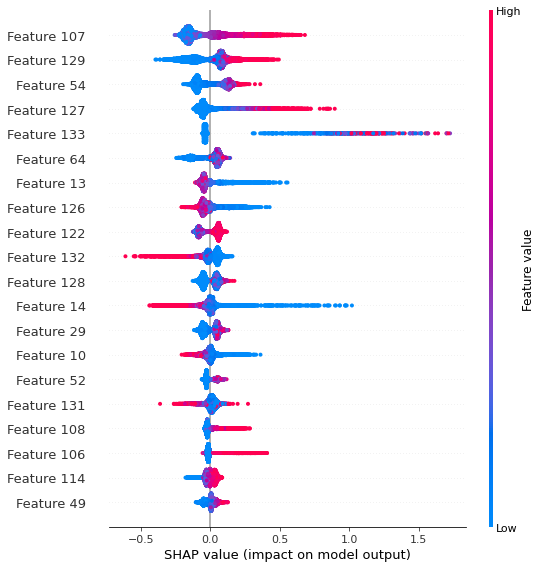

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

        # # summarize the effects of all the features
shap.summary_plot(shap_values, X_train)



---



---



---



# References
1. https://www.kaggle.com/meetnagadia/amazon-kindle-book-review-for-sentiment-analysis

2. https://towardsdatascience.com/boosting-showdown-scikit-learn-vs-xgboost-vs-lightgbm-vs-catboost-in-sentiment-classification-f7c7f46fd956

3. https://www.kaggle.com/altruistdelhite04/loan-prediction-problem-dataset

4. https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/

5. https://www.analyticsvidhya.com/blog/2021/04/how-to-use-catboost-for-mental-fatigue-score-prediction/

6. https://github.com/dmlc/xgboost/tree/master/demo/rank

7. https://github.com/catboost/tutorials/tree/master/ranking

8. https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRanker.html

9. https://www.microsoft.com/en-us/research/project/mslr/